# **1 - Perkenalan**

---



Bab pengenalan harus diisi dengan identitas, gambaran besar dataset yang digunakan, dan objective yang ingin dicapai.

# **3 - Import Libraries**

---



Cell pertama pada notebook harus berisi dan hanya berisi semua library yang digunakan dalam project.

In [38]:
# Importing libraries
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from statsmodels.tsa.seasonal import seasonal_decompose
import pylab
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Model Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA

# Visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Preprocessing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, classification_report, accuracy_score

# Importing Libraries
import pickle
import json

# Warning Library
import warnings
warnings.filterwarnings('ignore')

# **4 - Data Loading**

---



Bagian ini berisi proses penyiapan data sebelum dilakukan eksplorasi data lebih lanjut. Proses Data Loading dapat berupa memberi nama baru untuk setiap kolom, mengecek ukuran dataset, dll.

In [2]:
# Load the data
data = pd.read_csv('https://raw.githubusercontent.com/andik-alfauzi/Final-Project/main/sample_dataset_timeseries_noarea.csv')

In [3]:
# Copy the data make sure the original is untouchable
copyData = data.copy()

# Display Dataframe
copyData

,week_number,week_start_date,week_end_date,product_item,quantity
0,2021-52,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41
1,2021-52,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430
2,2021-52,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4
3,2021-52,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148
4,2021-52,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119
...,...,...,...,...,...
102728,2023-14,2023-04-03,2023-04-09,ff3890faa80ff425ae906e27bbc50bc6,907
102729,2023-14,2023-04-03,2023-04-09,ff4b0f3b9c78c91510a4e3920fbc5090,81
102730,2023-14,2023-04-03,2023-04-09,ff9d05a4d6f922b3ab1653f58165b8ce,16
102731,2023-14,2023-04-03,2023-04-09,ffbd6f1d884056a4f622d54ae79e5a14,42920


# **5 - Exploratory Data Analysis (EDA)**

---

Bagian ini berisi eksplorasi data pada dataset diatas dengan menggunakan query, grouping, visualisasi sederhana, dan lain sebagainya.



In [4]:
# Check data info
copyData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102733 entries, 0 to 102732
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   week_number      102733 non-null  object
 1   week_start_date  102733 non-null  object
 2   week_end_date    102733 non-null  object
 3   product_item     102731 non-null  object
 4   quantity         102733 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.9+ MB


In [5]:
# Decribing data
copyData.describe()

,quantity
count,102733.000000
mean,3191.562419
std,12074.631014
min,0.000000
25%,75.000000
50%,414.000000
75%,1890.000000
max,774732.000000


In [6]:
# Check null sales quantity
copyData.loc[(copyData['quantity'] == 0)]

,week_number,week_start_date,week_end_date,product_item,quantity
72589,2022-47,2022-11-21,2022-11-27,6adc4ddabd44c5aa2f4c6105ceda926a,0
74199,2022-48,2022-11-28,2022-12-04,6adc4ddabd44c5aa2f4c6105ceda926a,0
75806,2022-49,2022-12-05,2022-12-11,6adc4ddabd44c5aa2f4c6105ceda926a,0


In [7]:
# Data without zero values
copyData = copyData.loc[(copyData['quantity'] != 0)]

In [8]:
# Decribing data
copyData.describe()

,quantity
count,102730.000000
mean,3191.655622
std,12074.795003
min,2.000000
25%,75.000000
50%,414.000000
75%,1890.000000
max,774732.000000


In [9]:
# Check null sales quantity
copyData.loc[(copyData['quantity'] == 0)]

,week_number,week_start_date,week_end_date,product_item,quantity


In [10]:
# Check duplicated data
print('Data duplicated : {}'.format(copyData.duplicated().sum()))

Data duplicated : 0


In [21]:
df = copyData.groupby('week_start_date', as_index=False)['quantity'].sum()
df = pd.DataFrame(df)
df

,week_start_date,quantity
0,2021-12-27,128808
1,2022-01-03,3839557
2,2022-01-10,4138934
3,2022-01-17,4149077
4,2022-01-24,4824273
...,...,...
62,2023-03-06,4775638
63,2023-03-13,4787111
64,2023-03-20,4757590
65,2023-03-27,6001166


Text(0, 0.5, 'Quantity')

<Figure size 2000x1000 with 0 Axes>

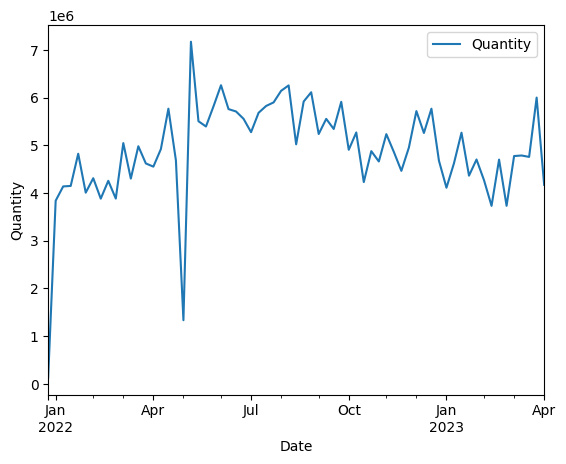

In [22]:
df.columns=['Date','Quantity']
df.Date=pd.to_datetime(df.Date)
df.set_index('Date',inplace=True)
plt.figure(figsize=(20, 10))
df.plot()
plt.xlabel('Date')
plt.ylabel('Quantity')

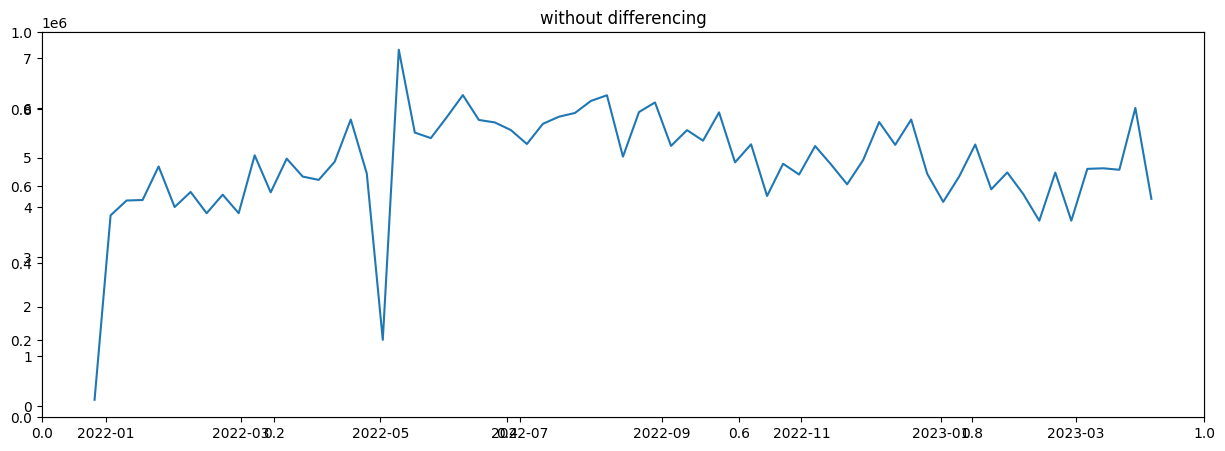

In [28]:
fig,ax=plt.subplots(figsize=(15,5))
ax1= fig.add_subplot(111)
ax1.set_title('without differencing')
ax1.plot(df['Quantity'])

In [34]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [35]:
check_stationarity(df['Quantity'])

ADF Statistic: -3.328832
p-value: 0.013638
Critical Values:
	1%: -3.537
	5%: -2.908
	10%: -2.591
Stationary


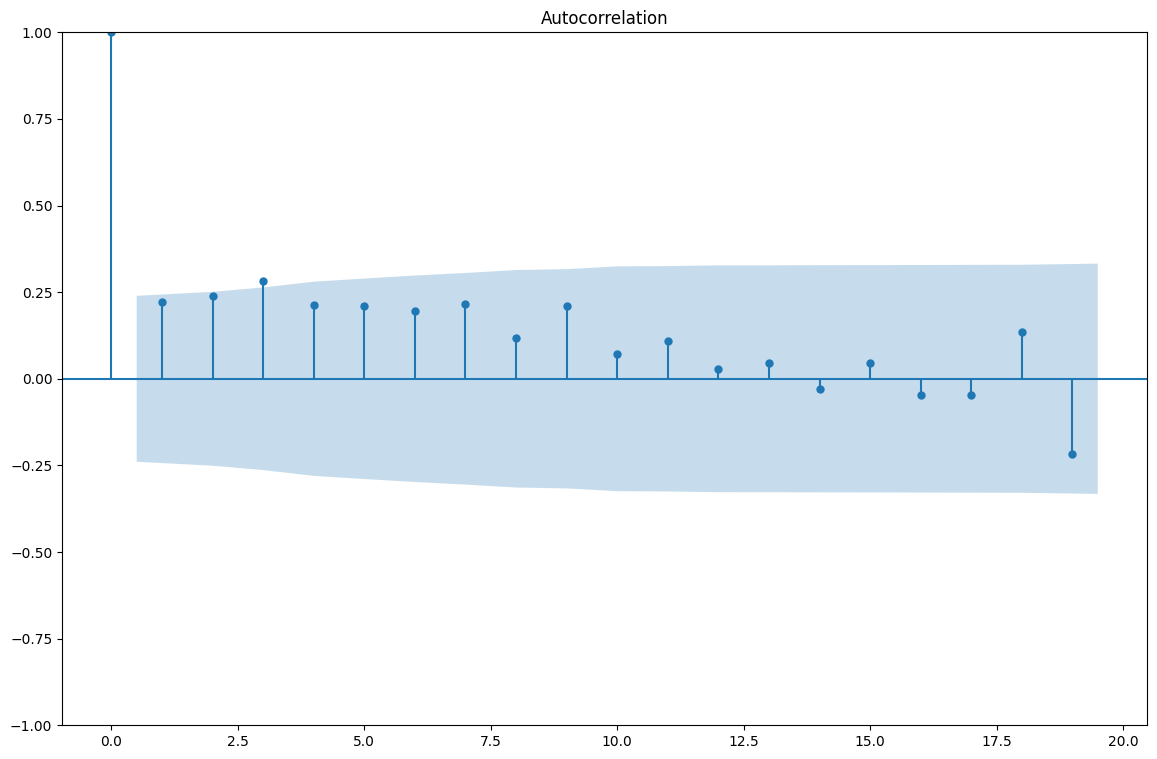

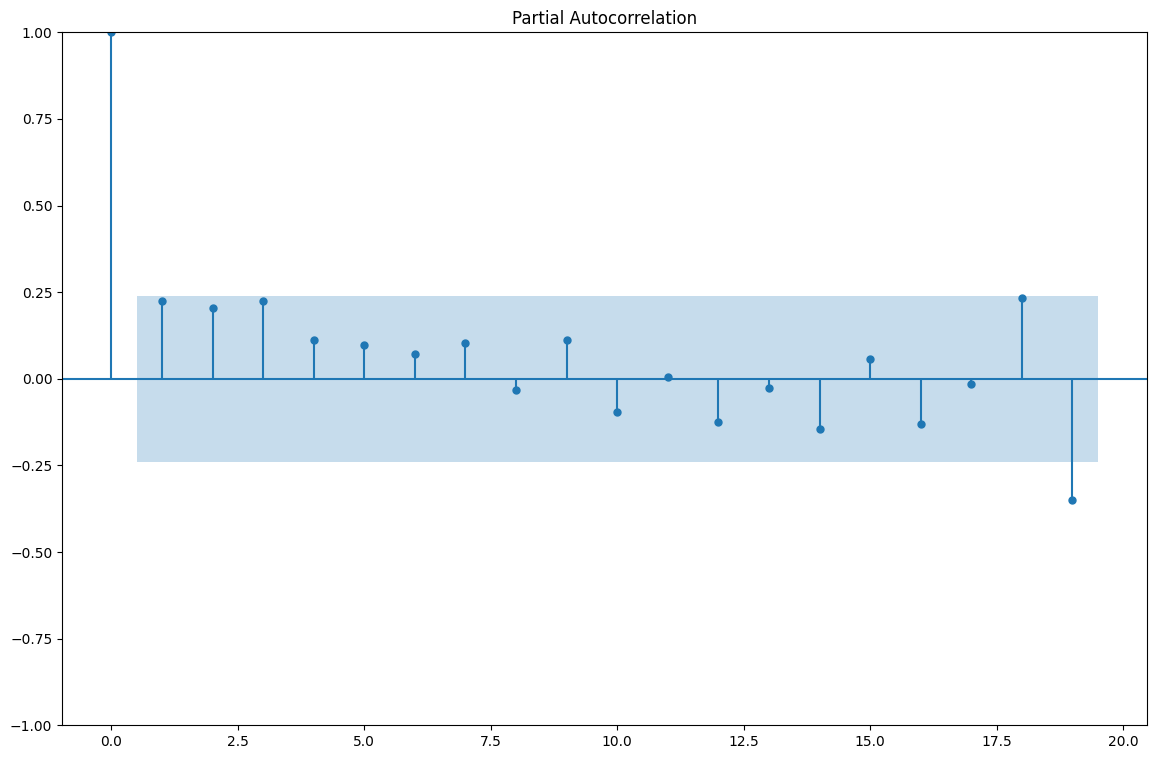

In [36]:
plot_acf(df['Quantity'])
plot_pacf(df['Quantity'])
plt.show()

In [39]:
def find_best_model(data,num_p,num_d,num_q):
    df=pd.DataFrame() #We make a pandas dataframe to ease our work, you can use any way that makes you comfortable and work easly
    pdq=[[],[],[]] #This list for storing the combinations of p and q
    aic=[] # This list for storing aic value
    for p in range(num_p+1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
        for d in range(num_d+1):
          for q in range(num_q+1):
            #if p!=0 and q!=0: #this logic will avoid (0,0) value which is not correct
                try: #Using exception to avoid the error while training the model with certain p and q value
                    model=ARIMA(data,order=(p,d,q))
                    result=model.fit()
                    pdq[0].append(p)
                    pdq[1].append(d)
                    pdq[2].append(q)
                    aic.append(result.aic)
                except:
                    pass #If there is an error caused by the calculation, it will be skipped to the next iteration
    df['p']=pdq[0]
    df['d']=pdq[1]
    df['q']=pdq[2]
    df['AIC']=aic
    
    df.sort_values('AIC',inplace=True)
    
    return df.p.iloc[0],df.d.iloc[0],df.q.iloc[0],df.AIC.iloc[0],df

In [41]:
find_best_model(df['Quantity'],3,3,3)

(3,
 3,
 2,
 1970.659018545115,
     p  d  q          AIC
 62  3  3  2  1970.659019
 63  3  3  3  1972.342434
 47  2  3  3  1973.354949
 46  2  3  2  1973.535770
 31  1  3  3  1978.651570
 .. .. .. ..          ...
 28  1  3  0  2062.882692
 34  2  0  2  2066.054594
 8   0  2  0  2066.539144
 12  0  3  0  2108.997734
 0   0  0  0  2265.949379
 
 [64 rows x 4 columns])

In [24]:
# # Visualize summary sales by week
# weeklySales = copyData.groupby('week_number', as_index=False)['quantity'].sum()
# itemWeeklySales = copyData.groupby(['product_item', 'week_number'], as_index=False)['quantity'].sum()

In [25]:
# weeklySalesSc = go.Scatter(x=weeklySales['week_number'], y=weeklySales['quantity'])
# layout = go.Layout(title='Daily sales', xaxis=dict(title='Week'), yaxis=dict(title='Quantity'))
# fig = go.Figure(data=[weeklySalesSc], layout=layout)
# iplot(fig)

In [26]:
# itemWeeklySalesSc = []
# for item in itemWeeklySales['product_item'].unique():
#     current_item_daily_sales = itemWeeklySales[(itemWeeklySales['product_item'] == item)]
#     itemWeeklySalesSc.append(go.Scatter(x=current_item_daily_sales['week_number'], y=current_item_daily_sales['quantity'], name=('Item %s' % item)))

# layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
# fig = go.Figure(data=itemWeeklySalesSc, layout=layout)
# iplot(fig)

# **6. Data Preprocessing**

---

Bagian ini berisi proses penyiapan data untuk proses pelatihan model, seperti pembagian data menjadi train-test, transformasi data (normalisasi, encoding, dll.), dan proses-proses lain yang dibutuhkan.

# **7 - Model Definition**

---

Bagian ini berisi cell untuk mendefinisikan model. Jelaskan alasan menggunakan suatu algoritma/model, hyperparameter yang dipakai, jenis penggunaan metrics yang dipakai, dan hal lain yang terkait dengan model.

# 8 - Model Training

---



Cell pada bagian ini hanya berisi code untuk melatih model dan output yang dihasilkan. Lakukan beberapa kali proses training dengan hyperparameter yang berbeda untuk melihat hasil yang didapatkan. Analisis dan narasikan hasil ini pada bagian Model Evaluation.

# **9 - Model Evaluation**

---

Pada bagian ini, dilakukan evaluasi model yang harus menunjukkan bagaimana performa model berdasarkan metrics yang dipilih. Hal ini harus dibuktikan dengan visualisasi tren performa dan/atau tingkat kesalahan model. Lakukan analisis terkait dengan hasil pada model dan tuliskan hasil analisisnya.

# **10 - Model Inference**

---

Model yang sudah dilatih akan dicoba pada data yang bukan termasuk ke dalam train-set ataupun test-set. Data ini harus dalam format yang asli, bukan data yang sudah di-scaled.

# **11 - Model Saving**

---


# **12 - Pengambilan Kesimpulan**

---


Pada bagian terakhir ini, harus berisi kesimpulan yang mencerminkan hasil yang didapat dengan objective yang sudah ditulis di bagian pengenalan.